In [0]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg

In [0]:
IMAGE_SIZE = (512, 512, 3)

content_path = 'images/pug.jpg'
style_path = 'images/legobw.jpg'

content_weights = {'block5_conv2': 1}

style_weights = {'block1_conv1': 0.2,
                'block2_conv1': 0.2,
                'block3_conv1': 0.2,
                'block4_conv1': 0.2,
                'block5_conv1': 0.2}

cost_layers = list(content_weights.keys()) + list(style_weights.keys())

In [0]:
def img_from(path):
    img = mpimg.imread(path)
    img = tf.image.resize(img, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    img = img[tf.newaxis, :]
    return img / 255 

In [0]:
def display_img(img, plt = plt, title=None):
    img = np.clip(((img * 255)[0]), 0, 255)
    plt.imshow(img.astype('uint8'))

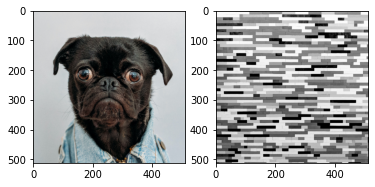

In [804]:
content_image = img_from(content_path)
style_image = img_from(style_path)

plt.subplot(1, 2, 1)
display_img(content_image, plt, 'Content Image')

plt.subplot(1, 2, 2)
display_img(style_image, plt, 'Style Image')

In [0]:
def get_vgg(cost_layers):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    
    # replace max pool with avg pool
    layers = [l for l in vgg.layers]
    current_out = layers[0].output
    for i in range(1, len(layers)):
        if layers[i].name[-4:] == 'pool':
            pool_layer = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
            current_out = pool_layer(current_out)
        else:
            current_out = layers[i](current_out)

    mod_vgg = tf.keras.Model(layers[0].input, current_out)
    
    layer_names = cost_layers
    outputs = [mod_vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([mod_vgg.input], outputs)
    model.trainable = False
    
    return model

In [0]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        
        super(StyleContentModel, self).__init__()
        self.vgg =  get_vgg(cost_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers

        
    def call(self, inputs):

        outputs = self.vgg(tf.keras.applications.vgg19.preprocess_input(inputs * 255))

        style_outputs = outputs[:len(style_weights)]
        content_outputs = outputs[len(style_weights):]
        
        content = {layer:output for layer, output in zip(self.content_layers, content_outputs)}
        style = {layer:output for layer, output in zip(self.style_layers, style_outputs)}

        return {'content':content, 'style':style}

In [0]:
style_weight = 40
content_weight = 10
learning_rate = 0.001

In [0]:
# define loss function

def get_gram(tensor):
    m, h, w, c = tensor.shape
    tensor = tf.reshape(tensor, (h * w, c))
    return tf.matmul(tf.transpose(tensor), tensor) / (h * w)


def norm_square(a, b):
    return tf.reduce_sum(tf.square(tf.subtract(a, b)))


def content_j(a, b):
    m, h, w, c = a.shape
    return tf.multiply(1 / (4 * c * h * w), norm_square(a, b))


def content_js(outputs, targets):
    loss = 0
    for layer_name in outputs.keys():
        loss += content_j(outputs[layer_name], targets[layer_name]) * content_weights[layer_name]
    return loss


def style_j(a, b):
    m, h, w, c = a.shape
    a = get_gram(a)
    b = get_gram(b)
    return tf.multiply(1 / (4 * ((h * w)**2) * (c**2)), norm_square(a, b))


def style_js(outputs, targets):
    loss = 0
    for layer_name in outputs.keys():
        loss += style_j(outputs[layer_name], targets[layer_name]) * style_weights[layer_name]
    return loss
    
    
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = style_js(style_outputs, style_targets)
    content_loss = content_js(content_outputs, content_targets)

    loss = style_weight * style_loss + content_weight * content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
    
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))
    
    return loss

extractor = StyleContentModel(list(style_weights.keys()), list(content_weights.keys()))
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=learning_rate)
losses = []

In [813]:
n_iter = 501
for i in range(len(losses), n_iter):
    loss = train_step(image)
    losses.append(loss.numpy())
    if i % 50 == 0:
        print('Iteration {}: {}'.format(i, losses[i]))
        mpl.image.imsave('legobw-{}-{}-{}-{}.png'.format(learning_rate, style_weight, content_weight, i), np.clip(((image)[0]), 0, 1))
        # outputs = extractor(image)
        # print('Style loss:', style_js(outputs['style'], style_targets).numpy())
        # print('Content loss:', content_js(outputs['content'], content_targets).numpy())
        # print()


Iteration 300: 34599.296875

Iteration 350: 31471.513671875

Iteration 400: 29121.6015625

Iteration 450: 27302.765625

Iteration 500: 25841.3515625



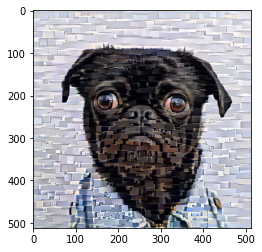

In [814]:
display_img(image)

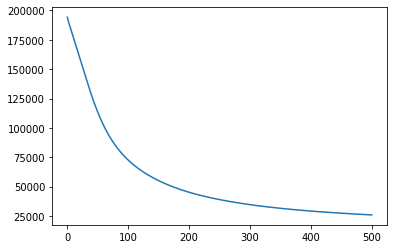

In [815]:
plt.plot([i for i in range(len(losses))], losses)